In [ ]:
import pandas as pd

df = pd.read_csv("simulation_data_original.csv")
print(df.head())

   Irrigation  SoilMoisture
0    0.000007      0.415582
1    0.000007      0.418537
2    0.000007      0.420380
3    0.000007      0.422251
4    0.000007      0.424674


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Extract input and output
input_data = df[['Irrigation']].values
output_data = df[['SoilMoisture']].values

# Normalize the data
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

input_scaled = input_scaler.fit_transform(input_data)
output_scaled = output_scaler.fit_transform(output_data)

# Create sequences for LSTM
def create_dataset(input_seq, output_seq, time_steps=3):
    X, y = [], []
    for i in range(len(input_seq) - time_steps):
        X.append(input_seq[i:i+time_steps])
        y.append(output_seq[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 3
X, y = create_dataset(input_scaled, output_scaled, time_steps)

In [ ]:
train_size = int(0.7 * len(X))

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
print(X_train.shape)

(7048, 3, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=16,
    verbose=1
)

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


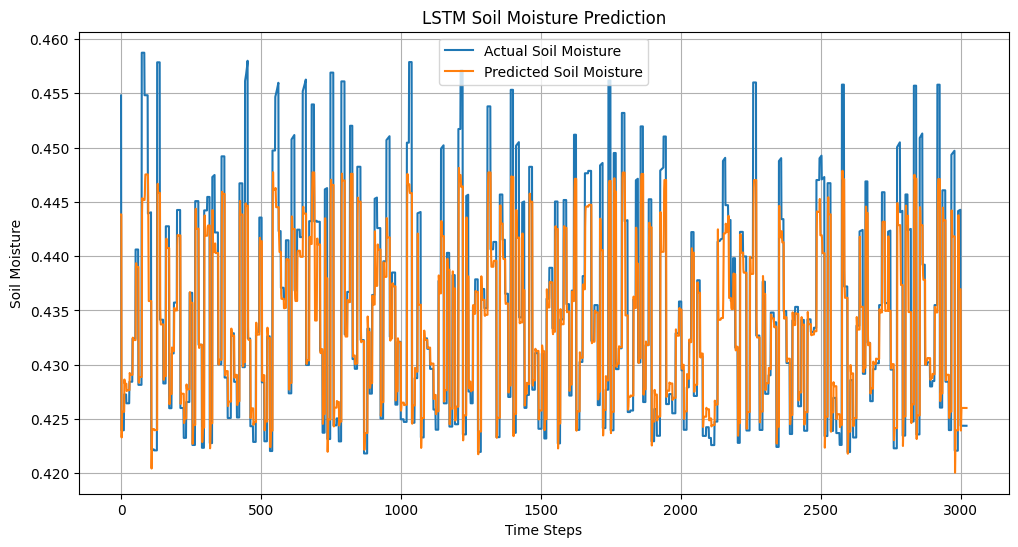

In [ ]:
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = output_scaler.inverse_transform(y_pred)
y_test_inv = output_scaler.inverse_transform(y_test)

# Plot results
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Soil Moisture')
plt.plot(y_pred_inv, label='Predicted Soil Moisture')
plt.legend()
plt.title("LSTM Soil Moisture Prediction")
plt.xlabel("Time Steps")
plt.ylabel("Soil Moisture")
plt.grid(True)
plt.show()

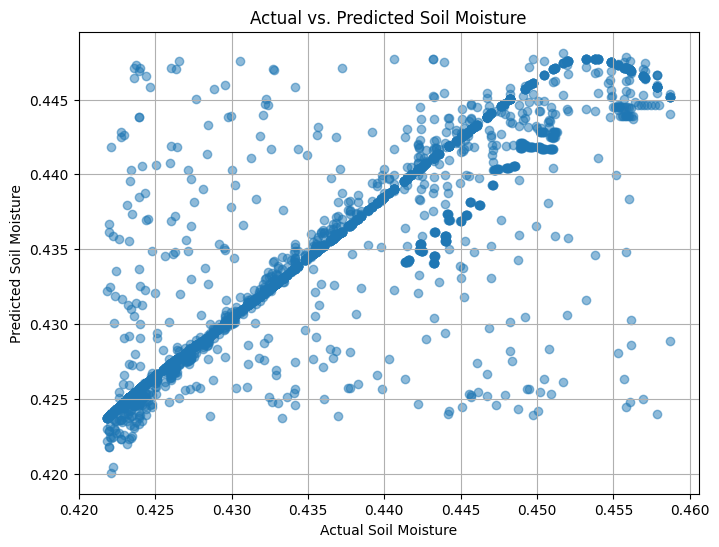

In [ ]:
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.scatter(y_test_inv, y_pred_inv, alpha=0.5)  # Alpha for transparency
plt.xlabel("Actual Soil Moisture")
plt.ylabel("Predicted Soil Moisture")
plt.title("Actual vs. Predicted Soil Moisture")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.0032
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0054
R² Score: 0.7168


**K-Means Clustering**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input

# Load data
df = pd.read_csv("simulation_data_original.csv")
print(df.head())

# Normalize
input_data = df[['Irrigation']].values
output_data = df[['SoilMoisture']].values
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()
input_scaled = input_scaler.fit_transform(input_data)
output_scaled = output_scaler.fit_transform(output_data)

   Irrigation  SoilMoisture
0    0.000007      0.415582
1    0.000007      0.418537
2    0.000007      0.420380
3    0.000007      0.422251
4    0.000007      0.424674


In [ ]:
print(input_scaled.shape)

(10072, 1)


In [ ]:
# Combine for clustering
X_clustering = np.hstack((input_scaled, output_scaled))

num_clusters = 3

print(f"Optimal no. of clusters using Silhouette score: {num_clusters}")

Optimal no. of clusters using Silhouette score: 3


In [ ]:
print(X_clustering.shape)

(10072, 2)


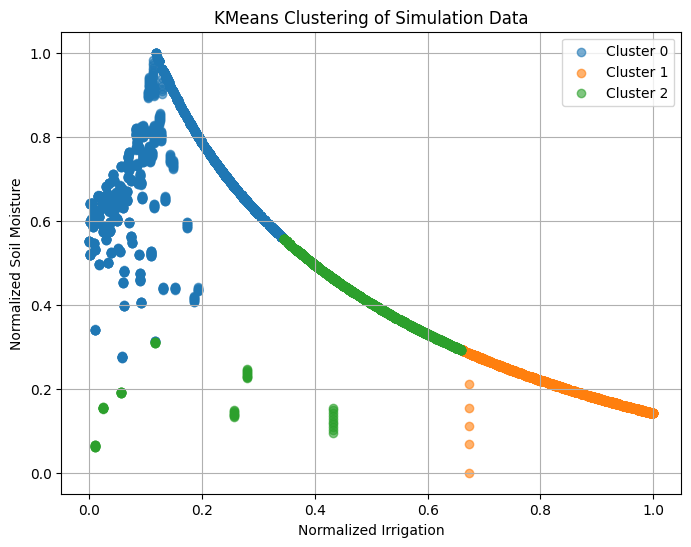

In [ ]:
# Final clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_clustering)

# Scatter plot of clusters
plt.figure(figsize=(8, 6))
for cluster in range(num_clusters):
    cluster_points = X_clustering[df['Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.6)

plt.xlabel("Normalized Irrigation")
plt.ylabel("Normalized Soil Moisture")
plt.title("KMeans Clustering of Simulation Data")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Sequence creation function
def create_dataset(input_seq, output_seq, time_steps=3):
    X, y = [], []
    for i in range(len(input_seq) - time_steps):
        X.append(input_seq[i:i+time_steps])
        y.append(output_seq[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 3
cluster_preds = []
cluster_truths = []
cluster_preds_with_indices = []
cluster_truths_with_indices = []
lstm_models = []  # store all trained models

for cluster in range(num_clusters):
    cluster_df = df[df['Cluster'] == cluster]
    input_cluster = input_scaler.transform(cluster_df[['Irrigation']].values)
    output_cluster = output_scaler.transform(cluster_df[['SoilMoisture']].values)

    X_cluster, y_cluster = create_dataset(input_cluster, output_cluster, time_steps)

    if len(X_cluster) < 10:
        continue

    train_size = int(0.7 * len(X_cluster))
    X_train_c, X_test_c = X_cluster[:train_size], X_cluster[train_size:]
    y_train_c, y_test_c = y_cluster[:train_size], y_cluster[train_size:]

    model = Sequential([
        Input(shape=(X_train_c.shape[1], X_train_c.shape[2])),
        LSTM(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_c, y_train_c, epochs=40, batch_size=16, verbose=1)

    lstm_models.append(model)

    # Predict on test set
    y_pred_c = model.predict(X_test_c)

    # 1️⃣ Store unordered predictions (for old plot)
    y_pred_inv_c = output_scaler.inverse_transform(y_pred_c).flatten()
    y_test_inv_c = output_scaler.inverse_transform(y_test_c).flatten()

    cluster_preds.extend(y_pred_inv_c)
    cluster_truths.extend(y_test_inv_c)

    # 2️⃣ Also store with indices (for ordered plot)
    indices = cluster_df.index[time_steps + train_size:]
    cluster_preds_with_indices.extend(zip(indices, y_pred_inv))
    cluster_truths_with_indices.extend(zip(indices, y_test_inv))


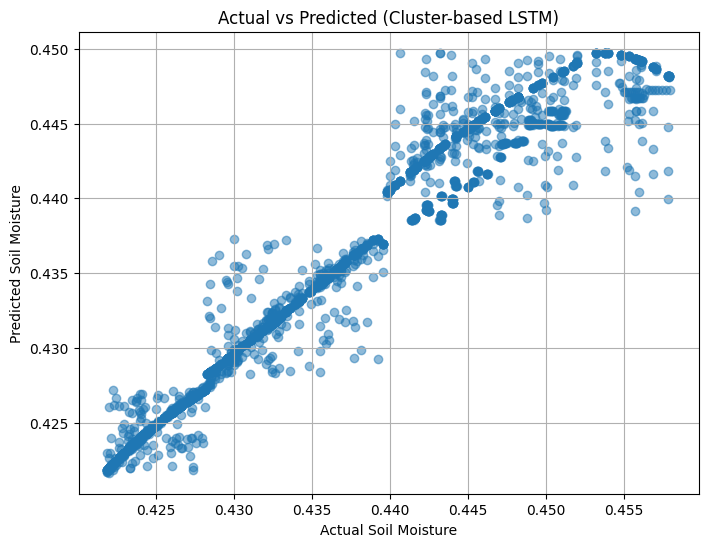

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(cluster_truths, cluster_preds, alpha=0.5)
plt.xlabel("Actual Soil Moisture")
plt.ylabel("Predicted Soil Moisture")
plt.title("Actual vs Predicted (Cluster-based LSTM)")
plt.grid(True)
plt.show()

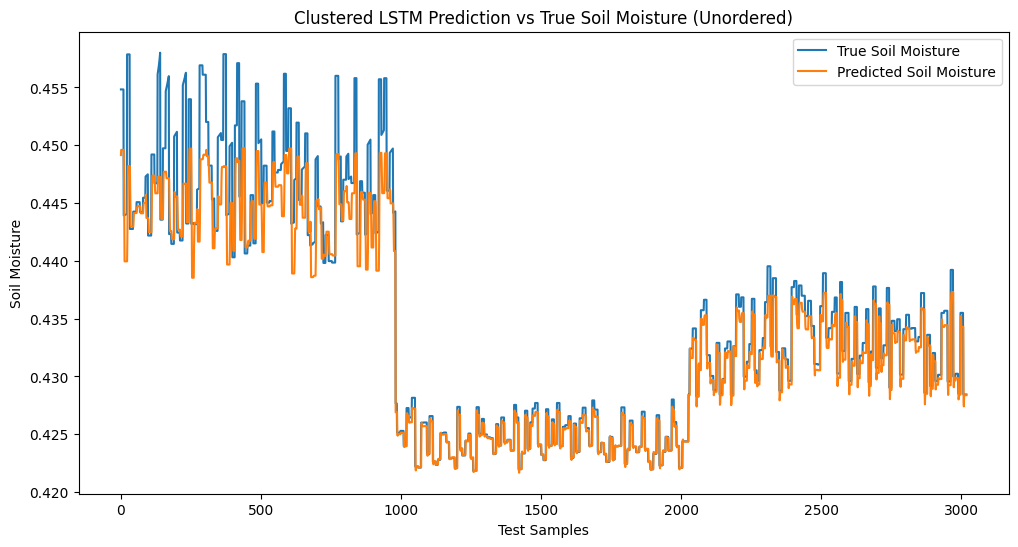

In [ ]:
# Plot 1: OLD — Unordered predictions
plt.figure(figsize=(12,6))
plt.plot(cluster_truths, label='True Soil Moisture')
plt.plot(cluster_preds, label='Predicted Soil Moisture')
plt.legend()
plt.title('Clustered LSTM Prediction vs True Soil Moisture (Unordered)')
plt.xlabel('Test Samples')
plt.ylabel('Soil Moisture')
plt.show()

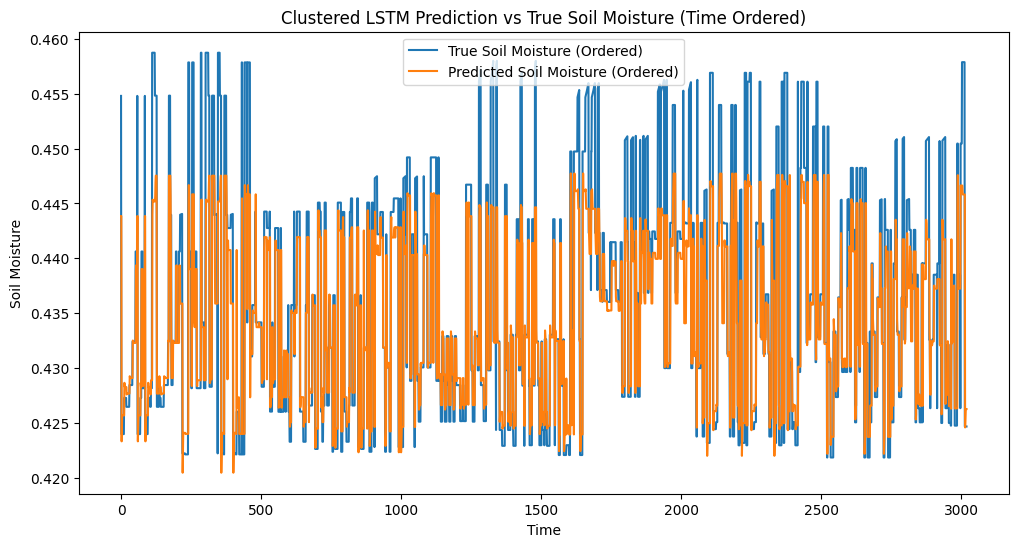

In [ ]:
cluster_preds_sorted = sorted(cluster_preds_with_indices, key=lambda x: x[0])
cluster_truths_sorted = sorted(cluster_truths_with_indices, key=lambda x: x[0])

sorted_pred_values = [pred for idx, pred in cluster_preds_sorted]
sorted_true_values = [true for idx, true in cluster_truths_sorted]

plt.figure(figsize=(12,6))
plt.plot(sorted_true_values, label='True Soil Moisture (Ordered)')
plt.plot(sorted_pred_values, label='Predicted Soil Moisture (Ordered)')
plt.legend()
plt.title('Clustered LSTM Prediction vs True Soil Moisture (Time Ordered)')
plt.xlabel('Time')
plt.ylabel('Soil Moisture')
plt.show()

In [ ]:
# Evaluation metrics
mae = mean_absolute_error(cluster_truths, cluster_preds)
mse = mean_squared_error(cluster_truths, cluster_preds)
rmse = np.sqrt(mse)
r2 = r2_score(cluster_truths, cluster_preds)

print(f"Optimal Clusters: {num_clusters}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Optimal Clusters: 3
Mean Absolute Error (MAE): 0.0016
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0027
R² Score: 0.9249


Predicting using average of all cluster LSTM models...
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
3021


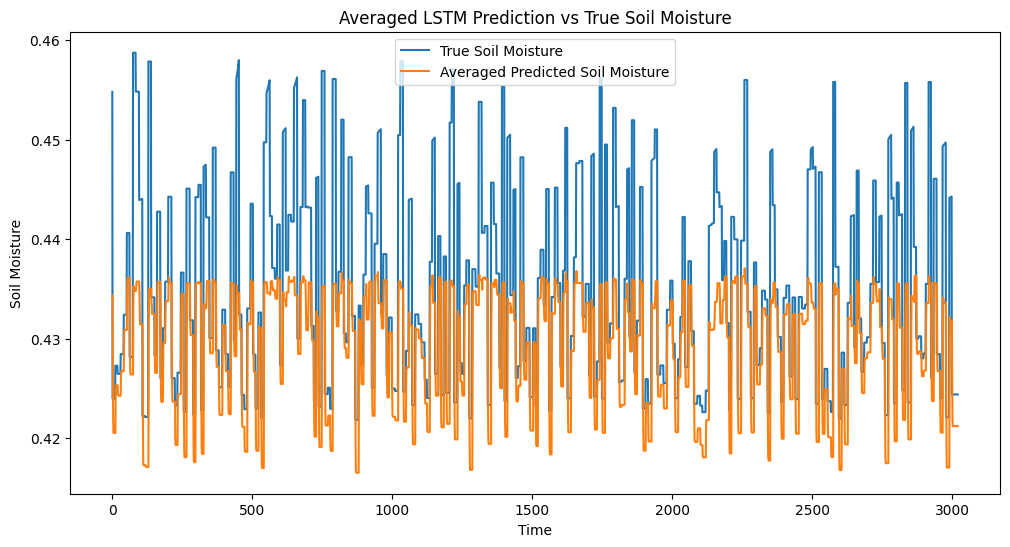

(3021,)
(3021,)


In [ ]:
print("Predicting using average of all cluster LSTM models...")

# Predict with each model and average
all_model_preds = []

for model in lstm_models:
    preds = model.predict(X_test)
    all_model_preds.append(preds.flatten())

# Average across models
avg_preds_scaled = np.mean(np.array(all_model_preds), axis=0)

# Inverse transform
avg_preds_inv = output_scaler.inverse_transform(avg_preds_scaled.reshape(-1, 1)).flatten()
y_test_inv_a = output_scaler.inverse_transform(y_test).flatten()

print(len(X_test))

# ---------------------------------------------
# Plot 3: AVERAGED PREDICTION
plt.figure(figsize=(12,6))
plt.plot(y_test_inv_a, label='True Soil Moisture')
plt.plot(avg_preds_inv, label='Averaged Predicted Soil Moisture')
plt.legend()
plt.title('Averaged LSTM Prediction vs True Soil Moisture')
plt.xlabel('Time')
plt.ylabel('Soil Moisture')
plt.show()

print(y_test_inv_a.shape)
print(avg_preds_inv.shape)

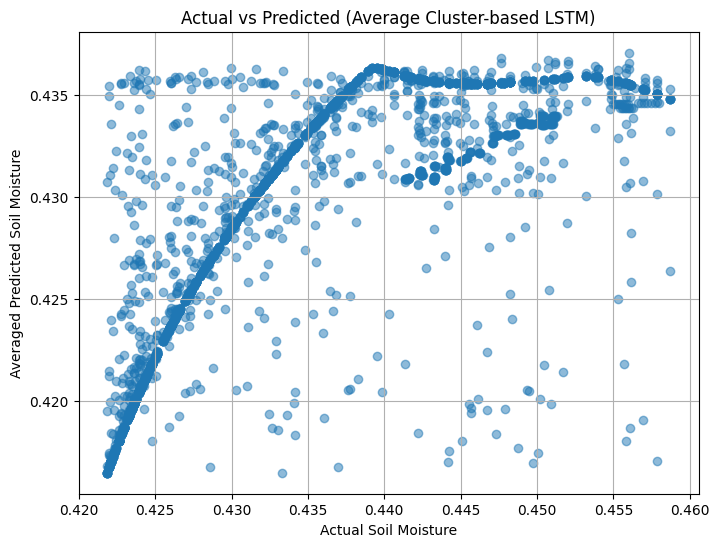

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_inv_a, avg_preds_inv, alpha=0.5)
plt.xlabel("Actual Soil Moisture")
plt.ylabel("Averaged Predicted Soil Moisture")
plt.title("Actual vs Predicted (Average Cluster-based LSTM)")
plt.grid(True)
plt.show()

In [ ]:
# --- Metrics for Average Ensemble LSTM ---
mae_avg = mean_absolute_error(y_test_inv_a, avg_preds_inv)
mse_avg = mean_squared_error(y_test_inv_a, avg_preds_inv)
rmse_avg = np.sqrt(mse_avg)
r2_avg = r2_score(y_test_inv_a, avg_preds_inv)

print("\n📈 Metrics for Averaged Ensemble LSTM Model:")
print(f"Mean Absolute Error (MAE): {mae_avg:.4f}")
print(f"Mean Squared Error (MSE): {mse_avg:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_avg:.4f}")
print(f"R² Score: {r2_avg:.4f}")



📈 Metrics for Averaged Ensemble LSTM Model:
Mean Absolute Error (MAE): 0.0064
Mean Squared Error (MSE): 0.0001
Root Mean Squared Error (RMSE): 0.0090
R² Score: 0.2024


**Dynamic Weight Adaptation** - Old code

In [ ]:
# Assuming X_full and y_full are the full sequences and lstm_models are the trained models
optimized_weights_predictions, optimized_weights_list = sliding_window_prediction(X_test, y_test, lstm_models, window_size)

# Inverse transform predictions
optimized_weights_predictions_inv = output_scaler.inverse_transform(optimized_weights_predictions.reshape(-1, 1)).flatten()

# Plotting the results (Aligning the predictions with the correct time step)
true_values_trimmed = y_test[window_size:]  # Exclude the first 20 points from the true values


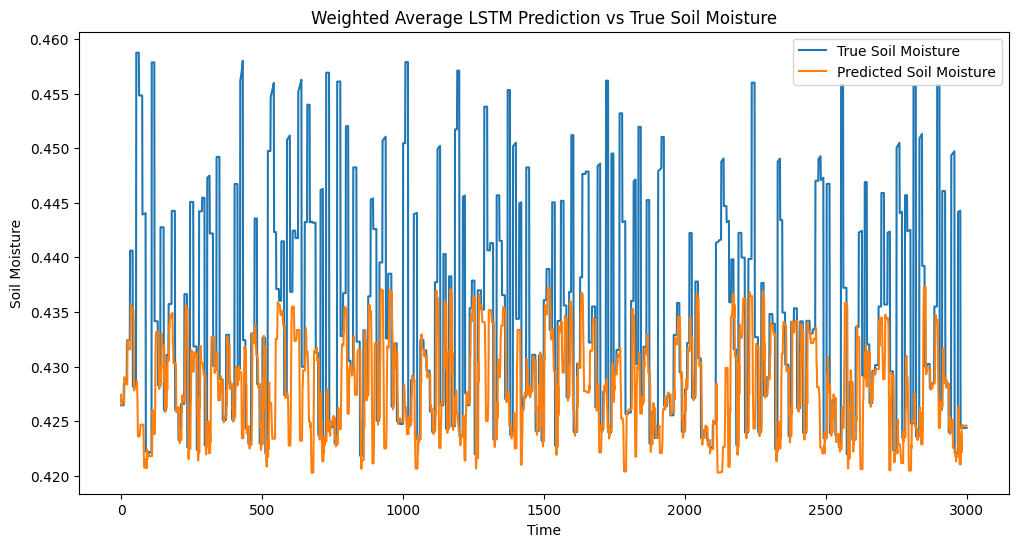

In [ ]:
true_values_trimmed = y_test_inv_a[window_size:]
plt.figure(figsize=(12,6))
plt.plot(true_values_trimmed, label='True Soil Moisture')
plt.plot(optimized_weights_predictions_inv, label='Predicted Soil Moisture')
plt.legend()
plt.title('Weighted Average LSTM Prediction vs True Soil Moisture')
plt.xlabel('Time')
plt.ylabel('Soil Moisture')
plt.show()

In [ ]:
# Find min and max in true_values_trimmed
true_values_min = true_values_trimmed.min()
true_values_max = true_values_trimmed.max()

# Find min and max in optimized_weights_predictions_inv
optimized_predictions_min = optimized_weights_predictions_inv.min()
optimized_predictions_max = optimized_weights_predictions_inv.max()

print(f"True Values - Min: {true_values_min}, Max: {true_values_max}")
print(f"Optimized Predictions - Min: {optimized_predictions_min}, Max: {optimized_predictions_max}")

True Values - Min: 0.4218315248807071, Max: 0.45874089198962403
Optimized Predictions - Min: 0.4202713192986793, Max: 0.43730125529020764


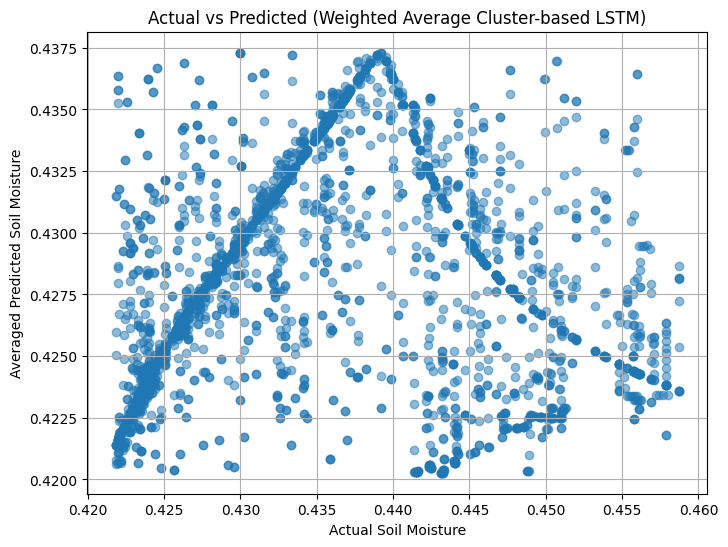

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(true_values_trimmed, optimized_weights_predictions_inv, alpha=0.5)
plt.xlabel("Actual Soil Moisture")
plt.ylabel("Averaged Predicted Soil Moisture")
plt.title("Actual vs Predicted (Weighted Average Cluster-based LSTM)")
plt.grid(True)
plt.show()

In [ ]:
mae_avg = mean_absolute_error(true_values_trimmed, optimized_weights_predictions_inv)
mse_avg = mean_squared_error(true_values_trimmed, optimized_weights_predictions_inv)
rmse_avg = np.sqrt(mse_avg)
r2_avg = r2_score(true_values_trimmed, optimized_weights_predictions_inv)

print("\n📈 Metrics for Weighted Averaged Ensemble LSTM Model:")
print(f"Mean Absolute Error (MAE): {mae_avg:.4f}")
print(f"Mean Squared Error (MSE): {mse_avg:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_avg:.4f}")
print(f"R² Score: {r2_avg:.4f}")


📈 Metrics for Weighted Averaged Ensemble LSTM Model:
Mean Absolute Error (MAE): 0.0081
Mean Squared Error (MSE): 0.0002
Root Mean Squared Error (RMSE): 0.0128
R² Score: -0.6018


New Code - Not working as expected

In [ ]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

# Define the sliding window and optimization function
window_size = 5
data_size = 100

# Function to calculate MSE between the weighted predictions and the actual values
def mse_loss(weights, predictions, actuals):
    weighted_pred = np.dot(predictions, weights)
    return mean_squared_error(actuals, weighted_pred)

# Prepare the predictions from all models
all_model_preds = []

# Get predictions from each LSTM model for the full dataset
for model in lstm_models:
    preds = model.predict(X_test)
    all_model_preds.append(preds.flatten())

# Convert the predictions into a numpy array
all_model_preds = np.array(all_model_preds)

print(all_model_preds.shape)

# Function to calculate the MSE loss
def mse_loss(weights, model_preds, true_values):
    weighted_preds = np.dot(model_preds, weights)  # Apply weights to model predictions
    mse = np.mean((weighted_preds - true_values) ** 2)
    return mse

# Function to calculate the predictions using the optimized weights for each window
def sliding_window_prediction(X_full, y_full, lstm_models, kmeans, window_size=20):
    optimized_weights_predictions = []
    optimized_weights_list = []  # To store the weights at each prediction point
    cluster_matches = []  # Store 1 if ensemble-cluster == true cluster, else 0

    # Initialize the equal weights (1/n for each model initially)
    initial_weights = np.ones(len(lstm_models)) / len(lstm_models)


    # Loop over the dataset, starting from index 20 (because the first 20 points are for optimizing)
    for i in range(window_size, len(X_full)):
        # Define the window for the current prediction (points 0 to i in the full dataset)
        X_window = X_full[i - window_size:i]
        y_window = y_full[i - window_size:i]

        print(f"\nCurrent Window {i - window_size + 1} to {i}")

        # Get the predictions from each model in the current window
        model_preds = np.array([model.predict(X_window) for model in lstm_models]).reshape(window_size, len(lstm_models))

        # Optimize the weights to minimize MSE
        result = minimize(mse_loss, initial_weights, args=(model_preds, y_window), bounds=[(0, 1)]*len(lstm_models), constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

        # Extract the optimized weights
        optimized_weights = result.x

        print(f"Optimized weights: {optimized_weights}")

        # Save the optimized weights for this prediction point
        optimized_weights_list.append(optimized_weights)

        # Now, calculate the prediction for the last point of the window (i.e., i-th point)
        weighted_preds = np.dot(model_preds[-1], optimized_weights)  # Weighted prediction for the last point
        optimized_weights_predictions.append(weighted_preds)

        # Update the initial guess for the next iteration (use the optimized weights from this step)
        initial_weights = optimized_weights

        # === Cluster Matching Logic ===

        input_feature = X_full[i][-1][0]     # The most recent input value (scalar)
        output_feature = y_full[i][0]        # The corresponding output value (scalar)

        last_point = np.array([[input_feature, output_feature]])  # Shape: (1, 2)
        print(f"last point: {last_point}")
        true_cluster = kmeans.predict(last_point)[0]
        ensemble_cluster = np.argmax(optimized_weights)

        is_match = int(ensemble_cluster == true_cluster)
        cluster_matches.append(is_match)

        print(f"True Cluster: {true_cluster + 1}, Ensemble-Favored: {ensemble_cluster + 1}, Match: {bool(is_match)}")

    # Overall match percentage
    match_percentage = 100 * np.mean(cluster_matches)
    print(f"\nCluster match accuracy: {match_percentage:.2f}%")

    return np.array(optimized_weights_predictions), np.array(optimized_weights_list)


In [ ]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

# Define the sliding window and optimization function
window_size = 20

# Function to calculate MSE between the weighted predictions and the actual values
def mse_loss(weights, predictions, actuals):
    weighted_pred = np.dot(predictions, weights)
    return mean_squared_error(actuals, weighted_pred)

# Prepare the predictions from all models
all_model_preds = []

# Get predictions from each LSTM model for the full dataset
for model in lstm_models:
    preds = model.predict(X_test)
    all_model_preds.append(preds.flatten())

# Convert the predictions into a numpy array
all_model_preds = np.array(all_model_preds)

print(all_model_preds.shape)

# Function to calculate the MSE loss
def mse_loss(weights, model_preds, true_values):
    weighted_preds = np.dot(model_preds, weights)  # Apply weights to model predictions
    mse = np.mean((weighted_preds - true_values) ** 2)
    return mse

# Function to calculate the predictions using the optimized weights for each window
def sliding_window_prediction(X_full, y_full, lstm_models, window_size=20):
    optimized_weights_predictions = []
    optimized_weights_list = []  # To store the weights at each prediction point

    # Initialize the equal weights (1/n for each model initially)
    initial_weights = np.ones(len(lstm_models)) / len(lstm_models)


    # Loop over the dataset, starting from index 20 (because the first 20 points are for optimizing)
    for i in range(window_size, len(X_full)):
        # Define the window for the current prediction (points 0 to i in the full dataset)
        X_window = X_full[i - window_size:i]
        y_window = y_full[i - window_size:i]

        print(f"\nCurrent Window {i - window_size + 1} to {i}")

        # Get the predictions from each model in the current window
        model_preds = np.array([model.predict(X_window) for model in lstm_models]).reshape(window_size, len(lstm_models))

        # Optimize the weights to minimize MSE
        result = minimize(mse_loss, initial_weights, args=(model_preds, y_window), bounds=[(0, 1)]*len(lstm_models), constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

        # Extract the optimized weights
        optimized_weights = result.x

        print(f"Optimized weights: {optimized_weights}")

        # Save the optimized weights for this prediction point
        optimized_weights_list.append(optimized_weights)

        # Now, calculate the prediction for the last point of the window (i.e., i-th point)
        weighted_preds = np.dot(model_preds[-1], optimized_weights)  # Weighted prediction for the last point
        optimized_weights_predictions.append(weighted_preds)

        # Update the initial guess for the next iteration (use the optimized weights from this step)
        initial_weights = optimized_weights

    return np.array(optimized_weights_predictions), np.array(optimized_weights_list)


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(3, 3021)


In [ ]:
print(f"KMeans expects {kmeans.n_features_in_} features per input sample.")

In [ ]:
# Assuming X_full and y_full are the full sequences and lstm_models are the trained models
X_test_m = X_test[:data_size]
y_test_m = y_test[:data_size]
optimized_weights_predictions, optimized_weights_list = sliding_window_prediction(X_test_m, y_test_m, lstm_models, kmeans, window_size)

# Inverse transform predictions
optimized_weights_predictions_inv = output_scaler.inverse_transform(optimized_weights_predictions.reshape(-1, 1)).flatten()

# Plotting the results (Aligning the predictions with the correct time step)
# true_values_trimmed = y_test_m[window_size:]  # Exclude the first 20 points from the true values
true_values_trimmed = y_test_inv_a[window_size:data_size]


In [ ]:
print(true_values_trimmed.shape)
print(optimized_weights_predictions_inv.shape)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(true_values_trimmed, label='True Soil Moisture')
plt.plot(optimized_weights_predictions_inv, label='Predicted Soil Moisture')
plt.axhline(y=0.43, color='r', linestyle='--', label='Threshold = 0.43')  # Add horizontal line
plt.legend()
plt.title('Weighted Average LSTM Prediction vs True Soil Moisture')
plt.xlabel('Time')
plt.ylabel('Soil Moisture')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(true_values_trimmed, optimized_weights_predictions_inv, alpha=0.5)
plt.xlabel("Actual Soil Moisture")
plt.ylabel("Averaged Predicted Soil Moisture")
plt.title("Actual vs Predicted (Weighted Average Cluster-based LSTM)")
plt.grid(True)
plt.show()

In [ ]:
mae_avg = mean_absolute_error(true_values_trimmed, optimized_weights_predictions_inv)
mse_avg = mean_squared_error(true_values_trimmed, optimized_weights_predictions_inv)
rmse_avg = np.sqrt(mse_avg)
r2_avg = r2_score(true_values_trimmed, optimized_weights_predictions_inv)

print("\n📈 Metrics for Weighted Averaged Ensemble LSTM Model:")
print(f"Mean Absolute Error (MAE): {mae_avg:.4f}")
print(f"Mean Squared Error (MSE): {mse_avg:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_avg:.4f}")
print(f"R² Score: {r2_avg:.4f}")